<a href="https://colab.research.google.com/github/Vanbk/Tensorflow/blob/master/2D1GGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# training params
num_steps = 50000
batch_size = 128
learning_rate = 0.0002

# Network params
image_dim = 784
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [0]:
# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
    'disc1_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc1_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
    'disc1_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc1_out': tf.Variable(tf.zeros([1])),
}

In [0]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator1(x):
    hidden_layer = tf.matmul(x, weights['disc1_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc1_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc1_out'])
    out_layer = tf.add(out_layer, biases['disc1_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

disc1_real = discriminator1(disc_input)
disc1_fake = discriminator1(gen_sample)

# Build Loss
gen_loss  = -tf.reduce_mean(tf.log(disc_fake) + tf.log(disc1_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

disc1_loss = -tf.reduce_mean(tf.log(disc1_real) + tf.log(1. - disc1_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc1 = tf.train.AdamOptimizer(learning_rate=learning_rate/2.0)
# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

disc1_vars = [weights['disc1_hidden1'], weights['disc1_out'],
            biases['disc1_hidden1'], biases['disc1_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
train_disc1 = optimizer_disc1.minimize(disc1_loss, var_list=disc1_vars)
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [0]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, _,gl, dl,dl1 = sess.run([train_gen, train_disc, train_disc1, gen_loss, disc_loss, disc1_loss],
                            feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f, Dis2 Loss: %f' % (i, gl, dl, dl1))

Step 1: Generator Loss: 1.238258, Discriminator Loss: 1.607805, Dis2 Loss: 1.343025
Step 1000: Generator Loss: 5.480768, Discriminator Loss: 0.076425, Dis2 Loss: 0.284239
Step 2000: Generator Loss: 7.974878, Discriminator Loss: 0.016501, Dis2 Loss: 0.097803
Step 3000: Generator Loss: 9.102035, Discriminator Loss: 0.013703, Dis2 Loss: 0.081299
Step 4000: Generator Loss: 6.767969, Discriminator Loss: 0.061506, Dis2 Loss: 0.162739
Step 5000: Generator Loss: 6.697447, Discriminator Loss: 0.125572, Dis2 Loss: 0.308254
Step 6000: Generator Loss: 6.352036, Discriminator Loss: 0.124414, Dis2 Loss: 0.306666
Step 7000: Generator Loss: 6.538425, Discriminator Loss: 0.115728, Dis2 Loss: 0.273679
Step 8000: Generator Loss: 6.692393, Discriminator Loss: 0.119623, Dis2 Loss: 0.341221
Step 9000: Generator Loss: 6.112867, Discriminator Loss: 0.278452, Dis2 Loss: 0.474000
Step 10000: Generator Loss: 5.981497, Discriminator Loss: 0.190740, Dis2 Loss: 0.342385
Step 11000: Generator Loss: 5.995409, Discrim

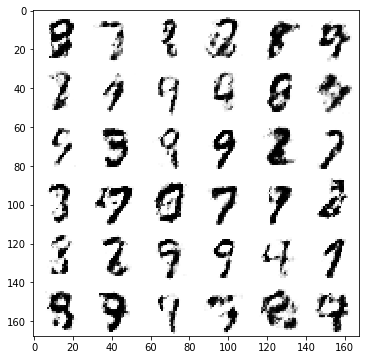

In [0]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()